### Import libraries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# Multivariate feature imputation method
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

# Feature combination on funder & installer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Numerical feature normalisation
from scipy.stats import zscore

# Categorical feature encoding
from sklearn.preprocessing import LabelEncoder

# Display feature's summary
from fast_ml import eda
from fast_ml.utilities import display_all

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./dataset/data_mining_water_table.csv')

---
# <ins>Data Wrangling & Pre-processing</ins>

## Custom Function

In [3]:
# Code adapted from https://stackoverflow.com/questions/58217005/how-to-reverse-label-encoder-from-sklearn-for-multiple-columns
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

In [4]:
# imp_column: Feature/column to impute
# groupby_features: Features to groupby
# transform_method: Method to apply to transformation, etc. mean, median, mode...
# df_waterpoint: The dataframe to be altered

def location_based_imputation(imp_column, groupby_features, transform_method, df_waterpoint):
    transformed_features = []
    included_features = groupby_features.copy()
    
    # Create a list to store the apply 'method' of location from smallest geographical area to the biggest
    for _ in groupby_features:
        # transformed_features.append(df.groupby(feature)[imp_column].transform(transform_method))
        transformed_features.append(df.groupby(included_features)[imp_column].transform(transform_method))
        included_features.pop()
        
    # Impute 'nan' base on the computed mean value of its correspond features 
    for transformed_feature in transformed_features:
        df_waterpoint[imp_column].fillna(transformed_feature, inplace=True)

In [5]:
sb_stemmer = SnowballStemmer('english')


def funder_installer_binning(value):
    
    if value is np.nan or len(value) == 0:
        return 'Unknown'
    
    if binning_helper(value, government_keyword):
        return 'Government'
    
    if binning_helper(value, aid_keyword):
        return 'Aid'
    
    if binning_helper(value, religious_keyword):
        return 'Religious'
    
    if binning_helper(value, international_keyword):
        return 'International'
    
    if binning_helper(value, community_keyword):
        return 'Community'
    
    if binning_helper(value, private_keyword):
        return 'Private'
    
    if value in unknown_keyword or value == len(value) * value[0]:
        return 'Unknown'
    
    return 'Other'


def binning_helper(value, keywords):
    tokenize_words = word_tokenize(value)
    stem_keywords = [sb_stemmer.stem(word) for word in keywords]

    for word in tokenize_words:
        stem_word = sb_stemmer.stem(word)
        if any(keyword in stem_word for keyword in stem_keywords):
            return True

        elif stem_word in stem_keywords:
            return True

    return False

## Pearson Correlation Coefficient

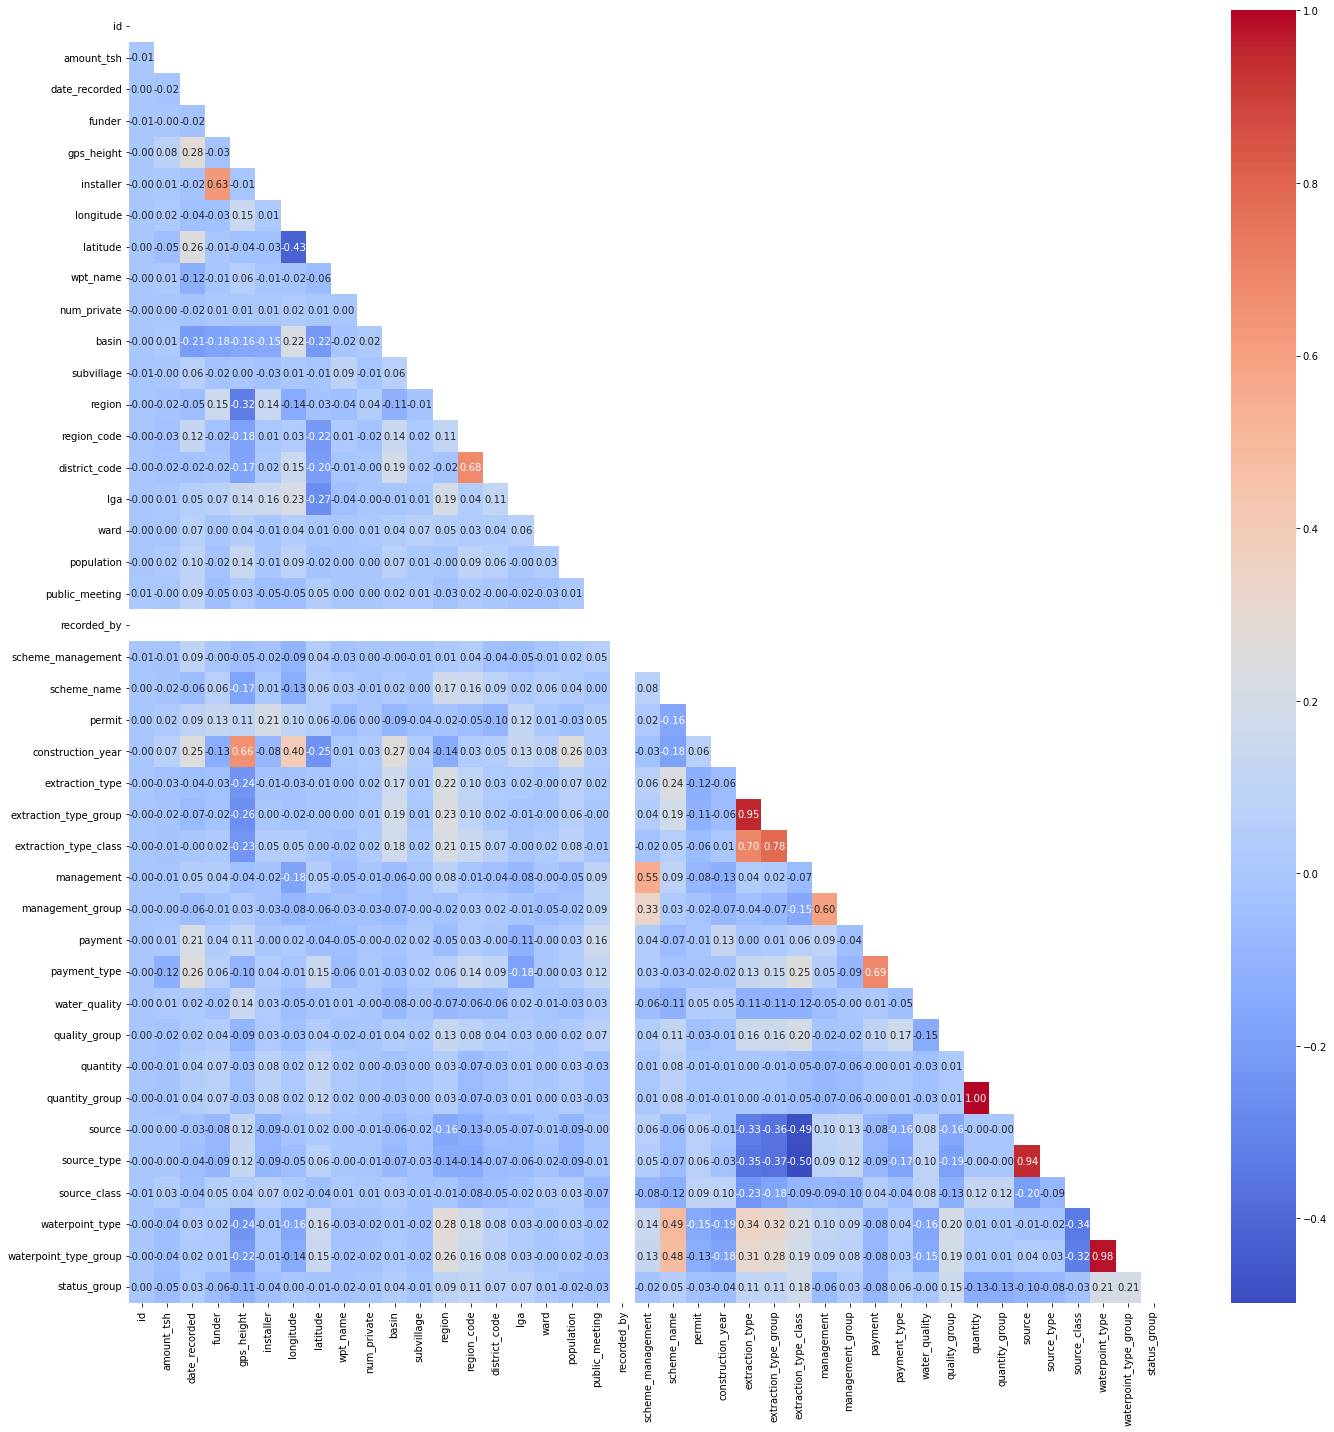

In [6]:
# store categorical features
categorical_features = []

for column in df.columns:
    if df[column].dtype == 'object':
        categorical_features.append(column)
      
# Encode categorical feature before visualise the pearson correlation's heatmap
df_temp = MultiColumnLabelEncoder(columns=categorical_features).fit_transform(df)

# Code reference from: https://cmdlinetips.com/2020/02/lower-triangle-correlation-heatmap-python/
corr_df = df_temp.corr('pearson')
# Create a triangle mask (shape) for the heatmap
mask_ut = np.triu(np.ones_like(corr_df, dtype=bool))
plt.subplots(figsize=(20, 20))
hmap = sns.heatmap(corr_df, mask=mask_ut, annot=True, fmt=".2f", cmap="coolwarm")
plt.tight_layout()

## 1. Imputation

### 1.1 gps_height
- 34.4% have gps_height of 0, 2.5% have negative gps_height.
- Impute the gps_height's missing values using the row's corresponding subvillage's mean if available, else ward lga, region (nearby waterpoint).
- Granularity (largest to smallest): basin -> region -> region_code -> district_code -> lga -> ward -> subvillage

In [7]:
# Replace all negative value with 0
df.loc[df['gps_height'] < 0, 'gps_height'] = 0

# Replace value 0 with 'Nan'
df['gps_height'].replace(0, np.nan, inplace=True)
df.loc[df['gps_height'].isna(), 'gps_height']

4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
         ..
59384   NaN
59392   NaN
59393   NaN
59397   NaN
59398   NaN
Name: gps_height, Length: 21934, dtype: float64

In [8]:
gps_height_features = ['basin', 'region', 'region_code', 'district_code', 'lga', 'ward', 'subvillage']

location_based_imputation('gps_height', gps_height_features, 'mean', df)

In [9]:
# Remove the floating points from the byproduct of mean
df['gps_height'] = round(df['gps_height'])

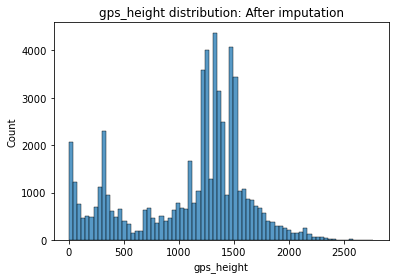

In [10]:
sns.histplot(data=df, x='gps_height')
plt.title('gps_height distribution: After imputation')
plt.show()

In [11]:
df.loc[df['gps_height'].isna(), 'ward']

Series([], Name: ward, dtype: object)

### 1.2 latitude & longitude
- Similar to gps_height, impute the missing values of lat & lon using the row's corresponding subvillage's mean if available, else ward lga, region.

In [12]:
df['longitude'].replace(0, np.nan, inplace=True)
df['latitude'].replace(-2.000000e-08, np.nan, inplace=True)

location_features = ['region', 'region_code', 'district_code', 'lga', 'ward', 'subvillage']

# Impute the longitude & latitude by the mean of the location features
location_based_imputation('longitude', location_features, 'mean', df)
location_based_imputation('latitude', location_features, 'mean', df)

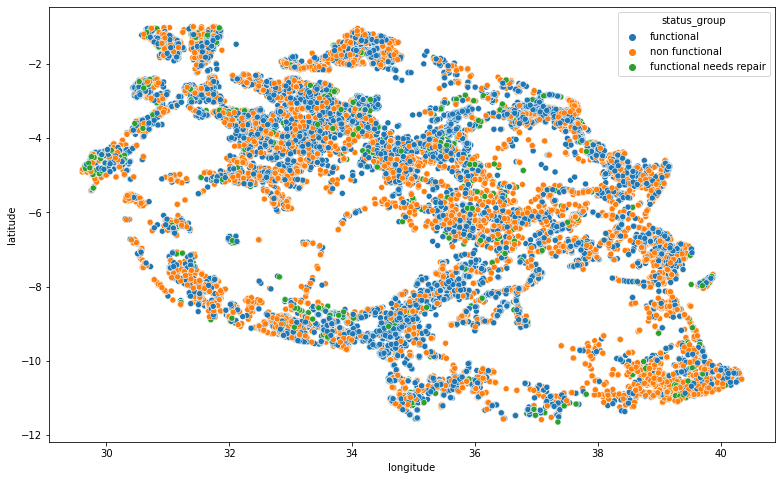

In [13]:
plt.subplots(figsize=(13, 8))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='status_group')
plt.show()

### 1.3 population
- The data is skewed due to the outliers, therefore median is employed as mean would be heavily influenced.
- Similar to gps_height & lat, lon, impute the missing values of lat & lon using the row's corresponding subvillage's median if available, else ward lga, region.

In [14]:
# Replace value 0 with 'Nan'
df['population'].replace(0, np.nan, inplace=True)

df.loc[df['population'].isna(), 'population']

4       NaN
6       NaN
7       NaN
8       NaN
9       NaN
         ..
59384   NaN
59392   NaN
59393   NaN
59397   NaN
59398   NaN
Name: population, Length: 21381, dtype: float64

In [15]:
population_features = ['basin', 'region', 'region_code', 'district_code', 'lga', 'ward', 'subvillage']

location_based_imputation('population', population_features, 'median', df)

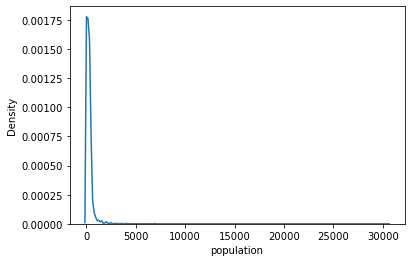

In [16]:
sns.kdeplot(data=df, x='population', fill=False)
# plt.xlim(0, 2000)
plt.show()

### 1.4 public_meeting
- Contains high mode percentage, low variance therefore not a good predictor for status_group.
- Not much information regarding this feauture from the feature description.
- replace the missing value by a new 'Unknown' class.

In [17]:
df['public_meeting'].fillna('Unknown', inplace=True)

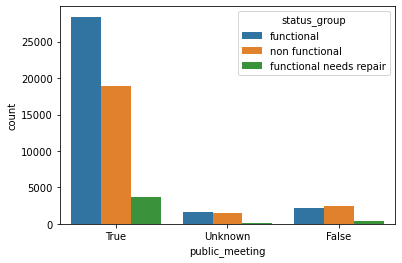

In [18]:
sns.countplot(data=df, x='public_meeting', hue='status_group')
plt.show()

### 1.5 scheme_management
- 3877 missing values, 1 None values.
- Relationship feature of scheme_management is management and management group.
- Impute scheme_management feture using above related features. First, assign 'Other' to the missing values of scheme_name. Encode the mentionned features follow by multivariate imputation.

In [19]:
management_columns = ['management', 'management_group', 'scheme_management']

# create a dataframe containing the relevant feature for scheme_management imputation
df_management = df[management_columns]

# convert the 1 instance of 'None' value of scheme_management to 'Nan'
df_management.loc[df_management['scheme_management'] == 'None', 'scheme_management'] = np.nan
df_management

,management,management_group,scheme_management
0,vwc,user-group,VWC
1,wug,user-group,Other
2,vwc,user-group,VWC
3,vwc,user-group,VWC
4,other,other,NaN
...,...,...,...
59395,water board,user-group,Water Board
59396,vwc,user-group,VWC
59397,vwc,user-group,VWC
59398,vwc,user-group,VWC


In [20]:
multi_label_encoder = MultiColumnLabelEncoder(columns=management_columns)

df_management = df_management.astype(str)
# Encode the categorical features of the dataframe
df_management = multi_label_encoder.fit_transform(df_management)

In [21]:
# Display the arrangement of encoded feature values before imputation
print(df_management['scheme_management'].unique())
print(df['scheme_management'].unique())

# The encoded 'Nan' value is always encoded as the maximum numerical value in the list
management_missing_value = df_management['scheme_management'].max()

# Display the total of Nan value before imputation
print('Total missing values before imputation:', (df_management['scheme_management'] == management_missing_value).sum())

[ 6  1 11  3  8  9  7 10  0  2  5  4]
['VWC' 'Other' nan 'Private operator' 'WUG' 'Water Board' 'WUA'
 'Water authority' 'Company' 'Parastatal' 'Trust' 'SWC' 'None']
Total missing values before imputation: 3878


In [22]:
# Multivariate imputer
mult_imputer = IterativeImputer(estimator=RandomForestClassifier(), max_iter=10, missing_values=management_missing_value, initial_strategy='most_frequent', random_state=42)

df_management = mult_imputer.fit_transform(df_management)

In [23]:
df_management = pd.DataFrame(df_management, columns=management_columns)
df_management

,management,management_group,scheme_management
0,7.0,4.0,6.0
1,7.0,4.0,1.0
2,7.0,4.0,6.0
3,7.0,4.0,6.0
4,1.0,1.0,1.0
...,...,...,...
59395,9.0,4.0,9.0
59396,7.0,4.0,6.0
59397,7.0,4.0,6.0
59398,7.0,4.0,6.0


In [24]:
# Display the arrangement of encoded feature values after imputation
print(df_management['scheme_management'].unique())

# Display the total of Nan value after imputation
print('Total missing values after imputation:', (df_management['scheme_management'] == management_missing_value).sum())

[ 6.  1.  3.  8.  9.  7. 10.  0.  2.  5.  4.]
Total missing values after imputation: 0


In [25]:
df_management = df_management.astype(int)
df_management = multi_label_encoder.inverse_transform(df_management)

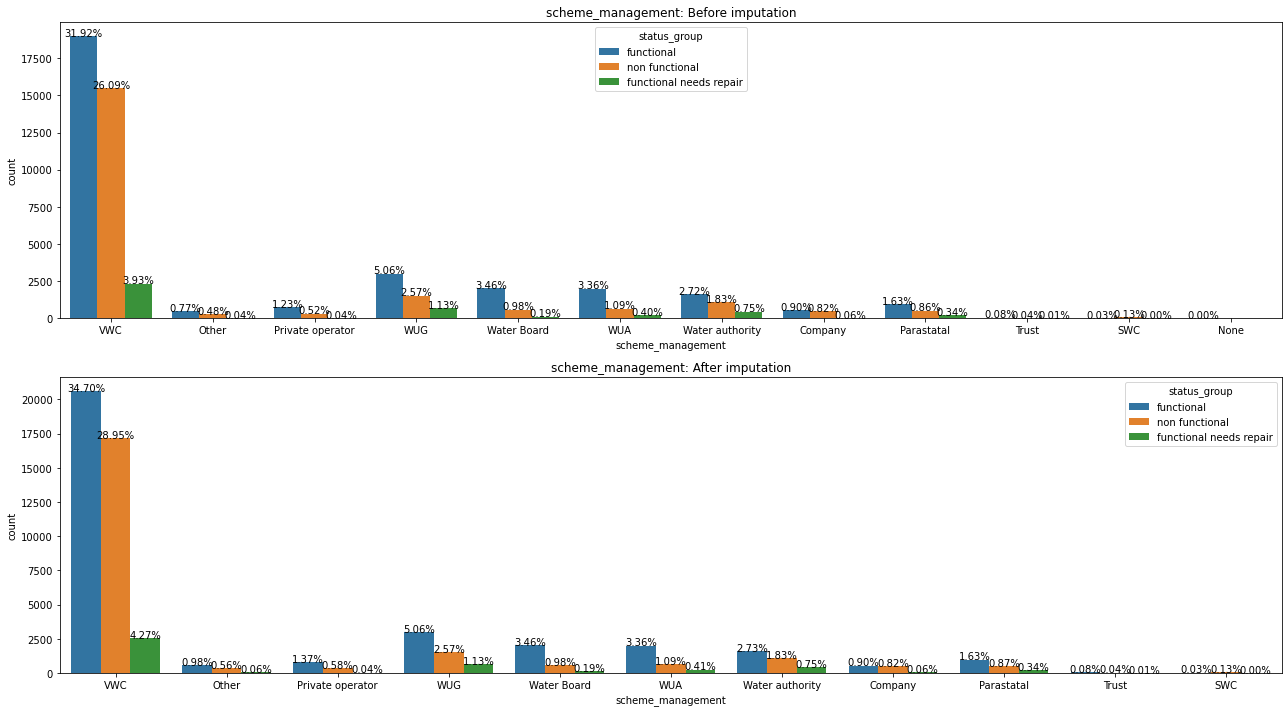

In [26]:
# Show the distribution before and after the imputation
fig, ax = plt.subplots(2, 1, figsize=(18, 10))
before_imp_scheme = sns.countplot(data=df, x='scheme_management', hue='status_group', ax=ax[0])
ax[0].set_title('scheme_management: Before imputation')
total = df.shape[0]

for patch in before_imp_scheme.patches:
    percentage = '{:.2f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height() 
    before_imp_scheme.annotate(percentage, (x, y), ha='center')
    
df_management['status_group'] = df['status_group']
after_imp_scheme = sns.countplot(data=df_management, x='scheme_management', hue='status_group', ax=ax[1])
ax[1].set_title('scheme_management: After imputation')

for patch in after_imp_scheme.patches:
    percentage = '{:.2f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    after_imp_scheme.annotate(percentage, (x, y), ha='center')
    
plt.tight_layout()
plt.show()

In [27]:
# Assigned the imputed scheme_management to the original dataframe
df['scheme_management'] = df_management['scheme_management']

### 1.6 permit

In [28]:
df['permit'].fillna('Unknown', inplace=True)

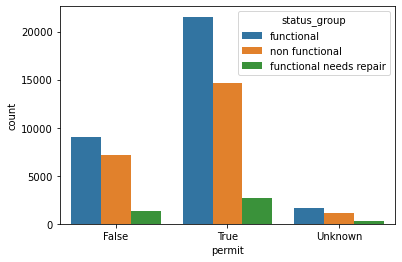

In [29]:
sns.countplot(data=df, x='permit', hue='status_group')
plt.show()

### 1.7 construction_year
- replace missing values with the mean of construction_year

In [30]:
df['construction_year'].replace(0, np.nan, inplace=True)
df['construction_year'].fillna(round(df['construction_year'].mean(axis=0, skipna=True)), inplace=True)

## 2. Feature Binning & Discretisation

### 2.1 funder & installer 

In [31]:
# Convert funder and installer values to lowercase
df['funder'] = df['funder'].str.lower()
df['installer'] = df['installer'].str.lower()

In [32]:
# Display the 30 most frequent funder and installer values
print('Funder')
print(df['funder'].value_counts(dropna=False).head(30), '\n')

print('Installer')
print(df['installer'].value_counts(dropna=False).head(30))

Funder
government of tanzania    9084
NaN                       3635
danida                    3114
hesawa                    2202
rwssp                     1374
world bank                1349
kkkt                      1287
world vision              1246
unicef                    1057
tasaf                      877
district council           843
dhv                        829
private individual         826
dwsp                       811
0                          777
norad                      765
germany republi            610
tcrs                       602
ministry of water          590
water                      583
dwe                        484
netherlands                470
hifab                      450
adb                        448
lga                        442
amref                      425
fini water                 393
oxfam                      359
wateraid                   333
rc church                  321
Name: funder, dtype: int64 

Installer
dwe                   17

In [33]:
government_keyword = ['gov', 'government', 'council', 'ministry', 'government', 'goverm', 'agency',
                      'district', 'department', 'tanzania', 'lga', 'dwe', 'dwsp', 'tasaf', 
                      'rwssp', 'wsdp', 'dmdd', 'water', 'depar', 'dhv', 'rwe']

religious_keyword = ['churc', 'catholic', 'muslim', 'mission', 'KKKT', 'Kanisa', 'lutherean', 'church', 
                     'TCRS', 'islam', 'Roman', 'sister', 'RC']

aid_keyword = ['aid', 'red cross', 'oxfam', 'unicef', 'world', 'world vision', 'adb', 'amref', 'adra',
               'acra', 'africa', 'club', 'quick', 'care', 'wfp', 'foundation', 'concern']

international_keyword = ['italy', 'japan', 'german', 'korea', 'niger', 'frankfurt', 'british', 'netherlands', 
                         'embassy', 'u.s.a', 'european union', 'holland', 'international', 'africa', 'finland', 
                         'unesco', 'irish', 'greec', 'swisland', 'imf', 'china','swedish', 'HIFAB', 'NORAD', 
                         'HESAWA', 'DANIDA', 'RUDEP', 'CES', 'GMBH', 'JICA', 'JAICA', 'belgian']

community_keyword = ['village', 'municipal', 'local', 'community', 'SHIPO', 'TWESA', 'SEMA', 'coun', 'commu']

private_keyword = ['private', 'individual', 'company', ' co', 'ltd', 'gold', 'construction', 'contractor',
                   'drilling']

# unknown includes entries with 1 character, nan and below list keyword
unknown_keyword = ['0', 'no', 'not known', 'none']

In [34]:
df['installer_group'] = df['installer'].apply(lambda value: funder_installer_binning(value))
df['funder_group'] = df['funder'].apply(lambda value: funder_installer_binning(value))

# Read from an imputed dataset
# df_funder_installer = pd.read_csv('./dataset/dataset_installer_funder.csv')
# df['installer_group'] = df_funder_installer['installer_group']
# df['funder_group'] = df_funder_installer['funder_group']

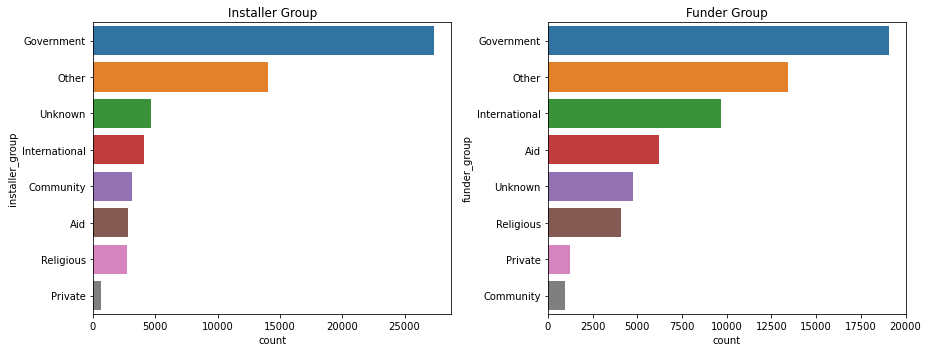

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
sns.countplot(data=df, y='installer_group', 
              order=df['installer_group'].value_counts().index, ax=ax[0])
ax[0].set_title('Installer Group')

sns.countplot(data=df, y='funder_group', 
              order=df['funder_group'].value_counts().index, ax=ax[1])
ax[1].set_title('Funder Group')

plt.tight_layout()
plt.show()

### 2.2 construction_year
- year binning.

In [36]:
# https://dfrieds.com/data-analysis/bin-values-python-pandas.html

# bins: (-1, 1959] exclusive -1, inclusive 1959
df['construction_by_decade'] = pd.cut(
    x=df['construction_year'],
    bins=[-1, 1959, 1969, 1979, 1989, 1999, 2009, 2019],
    labels=['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])

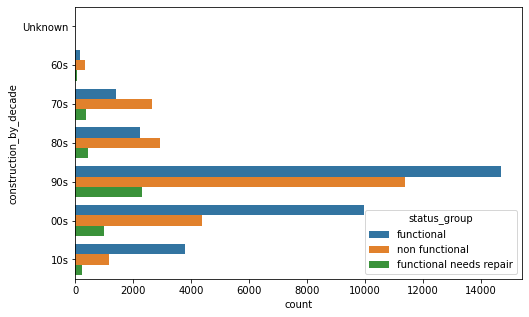

In [37]:
plt.subplots(figsize=(8, 5))
sns.countplot(data=df, y='construction_by_decade', hue='status_group')
plt.show()

## 3. Feature Engineering / Combination

### 3.1 missing_tsh

In [38]:
df['missing_tsh'] = np.where(df['amount_tsh'] == 0, 1, 0)

### 3.2 year_month_recorded
- only preserve the information of year and month from date_recorded feature.

In [39]:
df['year_recorded'] = pd.DatetimeIndex(df['date_recorded']).year
df['month_recorded'] = pd.DatetimeIndex(df['date_recorded']).month
df['year_month_recorded'] = df['year_recorded'].map(str) + '-' + df['month_recorded'].map(str)

df = df.drop(columns=['year_recorded', 'month_recorded'])

### 3.3 region_code_district_code
- combine region_code with district_code

In [40]:
df['region_code_district_code'] = df['region'] + '-' + df['region_code'].map(str) + '-' + df['district_code'].map(str)

## 4. Drop Features

In [41]:
features_to_drop = ['id', 'wpt_name', 'subvillage', 'ward', 'num_private', 'recorded_by', 
                    'management_group', 'scheme_name', 'lga',
                    'extraction_type_class', 'extraction_type_group', 
                    'payment_type', 'quality_group', 'quantity_group', 'source_class', 'source_type', 
                    'waterpoint_type_group', 'basin',
                    # feature engineered / feature combination
                    'date_recorded', 'installer', 'funder', 'region', 
                    'district_code', 'construction_year', 'amount_tsh', 'region_code']

df_imputed = df.drop(columns=features_to_drop)

## 5. Datatype Transformation

In [42]:
# Convert float to int
df_imputed['gps_height'] = df_imputed['gps_height'].astype(int)
df_imputed['population'] = df_imputed['population'].astype(int)


# convert features' datatype to string
features_to_str = ['permit', 'public_meeting', 'construction_by_decade']

for feature in features_to_str:
    df_imputed[feature] = df_imputed[feature].astype(str)

## 6. Numerical Feature Normalisation

In [43]:
df_imputed['gps_height'] = zscore(df_imputed['gps_height'])
df_imputed['population'] = zscore(df_imputed['population'])

## 7. Categorical Feature Encoding

In [44]:
categorical_features = []

# store categorical type features
for column in df_imputed.columns:
    if df_imputed[column].dtype == 'object':
        categorical_features.append(column)
        
categorical_features

['public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type',
 'status_group',
 'installer_group',
 'funder_group',
 'construction_by_decade',
 'year_month_recorded',
 'region_code_district_code']

In [45]:
df_cleaned = MultiColumnLabelEncoder(columns=categorical_features).fit_transform(df_imputed)
df_cleaned

,gps_height,longitude,latitude,population,public_meeting,scheme_management,permit,extraction_type,management,payment,...,quantity,source,waterpoint_type,status_group,installer_group,funder_group,construction_by_decade,missing_tsh,year_month_recorded,region_code_district_code
0,0.532076,34.938093,-9.856322,-0.360330,1,6,0,3,7,2,...,1,8,1,0,6,6,5,0,15,20
1,0.548919,34.698766,-2.147466,-0.001684,2,1,1,3,11,0,...,2,5,1,0,4,4,1,1,31,55
2,-0.785416,37.460664,-3.821329,-0.064604,1,6,1,3,7,4,...,1,0,2,0,0,0,0,0,30,52
3,-1.577034,38.486161,-11.155298,-0.467295,1,6,1,14,7,0,...,0,3,2,2,0,0,4,1,26,75
4,0.417919,31.130847,-1.825359,0.082210,1,1,1,3,1,0,...,3,5,1,0,4,4,5,1,19,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.195217,37.169807,-3.253847,-0.326773,1,9,1,3,9,4,...,1,8,1,0,3,3,5,0,33,38
59396,0.198960,35.249991,-9.070629,-0.471489,1,6,1,3,7,2,...,1,6,1,0,4,4,5,0,17,19
59397,-0.033098,34.017087,-8.750434,-0.379206,1,6,0,15,7,3,...,1,3,4,0,7,7,5,1,16,65
59398,-0.033098,35.861315,-6.378573,-0.379206,1,6,1,8,7,0,...,2,7,4,0,4,4,5,1,15,13


In [46]:
df_cleaned.to_csv('./dataset/cleaned_data_mining_water_table.csv', index=False)

## Summary of Data

In [47]:
summary_df = eda.df_info(df_cleaned)
display_all(summary_df)

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
gps_height,float64,Numerical,2368,"[0.5320763054285026, 0.548919246977196, -0.785...",0,0.0
longitude,float64,Numerical,57524,"[34.93809275, 34.6987661, 37.46066446, 38.4861...",0,0.0
latitude,float64,Numerical,57525,"[-9.85632177, -2.14746569, -3.82132853, -11.15...",0,0.0
population,float64,Numerical,1053,"[-0.360330074056652, -0.0016837037203895945, -...",0,0.0
public_meeting,int32,Numerical,3,"[1, 2, 0]",0,0.0
scheme_management,int32,Numerical,11,"[6, 1, 3, 8, 9, 7, 10, 0, 2, 5]",0,0.0
permit,int32,Numerical,3,"[0, 1, 2]",0,0.0
extraction_type,int32,Numerical,18,"[3, 14, 15, 8, 4, 9, 6, 7, 17, 0]",0,0.0
management,int32,Numerical,12,"[7, 11, 1, 4, 9, 10, 0, 8, 3, 6]",0,0.0
payment,int32,Numerical,7,"[2, 0, 4, 6, 5, 1, 3]",0,0.0
